# Lecture 7: Markov Chain Monte Carlo (MCMC) 
## ——现代贝叶斯分析的内核

## Instructor： 胡传鹏（博士）[Dr. Hu Chuan-Peng]

### 南京师范大学心理学院[School of Psychology, Nanjing Normal University]

课前回顾: 

- 概率基础;

- 贝叶斯公式中各个部分的意义

- 理解后验分布及其计算

## $p(\theta|data) = \frac{p(data|\theta)p(\theta)}{\pmb {p(data)}}$

使用贝叶斯公式的目标：

## $\pmb{p(\theta|data)} = \frac{p(data|\theta)p(\theta)}{p(data)}$ 

**以探究地球海水覆盖率为例。**

- 假设我们在获得数据以前的**先验**认为：地球海水覆盖率$\theta$为0-1的可能是相等的。$\theta \sim uniform(0,1)$

- 数据：抛地球仪9次，其中6次海面朝上。

- 以二项分布函数作为**似然函数**。

**我们该如何计算后验分布**

第一个方法是利用贝叶斯公式$p(\theta|data) = \frac{p(data|\theta)p(\theta)}{p(data)}$ 求出后验分布的解析解

但是可能的困难在于

1. 很多情况下求积分往往是很难的，并且有些积分可能没有解析解。
$P(data) =\int_{\theta}^{} p(data,\theta) =\int_{\theta}^{} p(data|\theta)p(\theta)d\theta$


2. 若后验分布比较复杂，即使获得后验分布，也难以计算期望值。
$E(\theta) =\int_{\theta}^{} \theta p(\theta|data) d\theta$

第二种方法：近似求解算法

## Part 1: The idea of approximation

### Grid approximation

最简单的近似方法就是网格近似。

虽然大多数参数都是连续的，能够接受无穷多的值。

但有时候通过有限的参数值，就可以很好地近似连续参数的后验分布

In [2]:
import numpy as np                             # numpy 是专门用于数组运算的包
import scipy.stats as st                       # 从scipy.stats里载入分布函数
import matplotlib.pyplot as plt                # matplotlib.pyplot 是专门用于画图的包
import seaborn as sns                          # seaborn是专门用于绘制统计数据的包
import arviz as az                             # arviz 是专门用于贝叶斯统计会绘制的包
from scipy.stats import norm, uniform, binom   # 从scipy.stats里载入正态分布和均匀分布
from math import sqrt                          # 从math包输入计算平方根的公式
from matplotlib.patches import Circle          # matplotlib.patches是用来画几何图形的包
sns.set_style("white")                         # 选择一个seaborn的风格

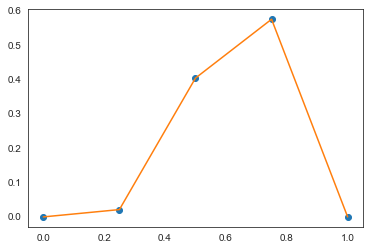

In [3]:
p_grid = np.linspace(0,1,5)        # 取5个离散的参数值
prior = np.repeat(1,5)             # 5个参数值的不标准的先验分布
likelihood = binom.pmf(6,9,p_grid) # 投掷9次，6次海面朝上的各参数的似然
unstd_posterior = likelihood*prior #没有归一化的后验分布

posterior = unstd_posterior/np.sum(unstd_posterior) # 后验分布归一化

plt.plot(p_grid,posterior,'o') #画出5个值的点
plt.plot(p_grid,posterior) #将5个值得点进行连线

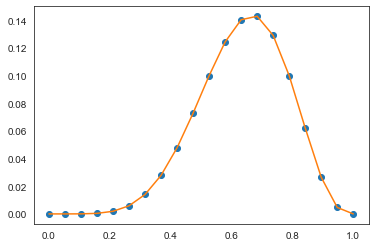

In [4]:
p_grid = np.linspace(0,1,20)       # 取20个离散的参数值
prior = np.repeat(1,20)            # 20个参数值的不标准的先验分布
likelihood = binom.pmf(6,9,p_grid) # 投掷9次，6次海面朝上的各参数的似然
unstd_posterior = likelihood*prior # 没有归一化的后验分布
posterior = unstd_posterior/np.sum(unstd_posterior) # 后验分布归一化
plt.plot(p_grid,posterior,'o')     # 画出20个值的点
plt.plot(p_grid,posterior)         # 将20个值的点进行连线

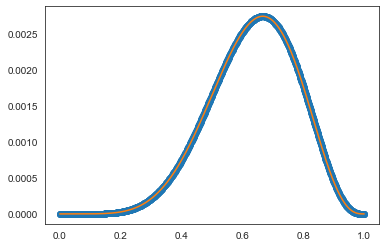

In [5]:
p_grid = np.linspace(0,1,1000)     # 取1000个离散的参数值
prior = np.repeat(1,1000)          # 20个参数值的不标准的先验分布
likelihood = binom.pmf(6,9,p_grid) # 投掷9次，6次海面朝上的各参数的似然
unstd_posterior = likelihood*prior # 没有归一化的后验分布
posterior = unstd_posterior/np.sum(unstd_posterior) #后验分布归一化

plt.plot(p_grid,posterior,'o')#画出1000个值的点
plt.plot(p_grid,posterior)#将1000个值的点进行连线

从以上代码可以看出：grid approximation 其实就是将连续参数求积分的过程转化为离散参数求和的过程

当只存在一个参数时，grid approximation 时很有用的，但是当存在两个以上参数时， grid approximation就需要大量计算

假如只有一个参数时，grid approximation计算时取100个参数值，则当存在2个参数时，就需要计算 $100^2=10000$个参数值

### 马尔科夫链蒙特卡洛(markov chain monte carlo, MCMC)

在计算具有多个参数的后验分布时，有一种有效的方法叫做马尔科夫链蒙特卡洛(MCMC)。

在介绍MCMC之前，我们先分别介绍一下蒙特卡洛方法(monte carlo)和马尔科夫链(markov chain)。

#### 蒙特卡洛方法

蒙特卡洛方法来自于摩纳哥的蒙特卡洛赌场，许多纸牌类游戏需要计算其胜利的概率。

我们可以将蒙特卡洛理解为简单的模拟，通过模拟的情景来计算其发生的概率。

因为许多概率的计算往往是非常复杂甚至是无法直接计算的，但是我们可以通过计算机对期待发生的场景进行大量模拟，从而计算出其发生的概率，即：

$p(发生的概率)=\frac{模拟情形下事件发生的次数}{模拟的次数}$

我们使用一个经典的例子来说明蒙特卡罗方法的原理。

我们可以用蒙特卡洛方法来求出不规则图形的面积。

其基本原理为用大量的随机点铺满整块区域（该区域为规则图形），其中不规则图形的面积为
$\frac{落在不规则图形内的点的数量}{该区域内点的数量}*该区域面积$

我们该如何计算图形下半部分面积？

In [4]:
x = np.linspace(-2,2,400)     # 取-2到2间的400个点
y = x**3+2                    # 通过非线性关系来获得y的取值   
plt.plot(x,y,color = 'black')

n = 100000                         # 随机点的数量
uniform_x = uniform(-2 , 4).rvs(n) # 从-2到2之间随机取100000个点
uniform_y = uniform(-8, 16).rvs(n) # 从-8到8之间随机取100000个点
plt.plot(x,y)
plt.gca().axes.set_ylim(-8, 8)     # 将x轴限定在-8到8
plt.gca().axes.set_xlim(-2, 2)     # 将y轴限定在-2到2

(-2.0, 2.0)

<Figure size 432x288 with 1 Axes>

In [7]:
count = 0     # 落在目标区域的点的数量
target_x = [] # 落在目标区域的点的x值
target_y = [] # 落在目标区域的点的y值

for i in range(n):# 对每一个点做一次判断
    if  uniform_y[i] <= uniform_x[i]**3+2:  # 击中点的特征，y<= x^3 +2
        count += 1                          # 击中点的数量+1
        target_x.append(uniform_x[i])       # 将击中点的x值加入到击中点x值的集合中
        target_y.append(uniform_y[i])       # 将击中点的y值加入到击中点y值的集合中

plt.scatter(uniform_x, uniform_y) # 绘制全部的点的图
plt.scatter(target_x,target_y)   # 绘制目标点的图
plt.gca().axes.set_ylim(-8, 8)

s = (count/n)*(4*16) #计算不规则图形面积
print(f"图形下半部分面积为{s}")

图形下半部分面积为39.81824


<Figure size 432x288 with 1 Axes>

可以将蒙特卡洛理解为一种模拟事件发生的方法。

使用蒙特卡洛方法进行采样时，常见做法是：接受-拒绝采样。

为了求解一个不常见的分布$p(x)$，先构造一个常见的分布$q(x)$进行采样，然后按照一定的方法拒绝某些样本，以达到接近 $p(x)$ 分布的目的，其中$q(x)$叫做 proposal distribution(建议分布)。

假定我们有一个不常见的概率分布$p(x)$，已知该分布的先验为均匀分布，似然函数已知，想要计算该参数的后验分布

In [18]:
x = np.arange(-4, 6, 0.01) # 生成从-4到6的数列

# 定义一个不常见的分布
def p_func(x):
    res = (0.3 * np.exp(-(x - 0.3) ** 2) + 0.7 * np.exp(-(x - 2) ** 2 / 0.3)) /1.21
    return res

plt.plot(x, p_func(x), color = 'r', lw = 5, label = 'p_func(x)') #画分布的形态

<Figure size 432x288 with 1 Axes>

In [10]:
norm_rv = norm(loc = 1.4, scale = 1.2) # 建议分布
c = 3 # 使建议分布的每个值大于目标分布的参数

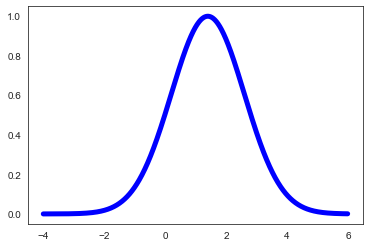

In [12]:
x = np.arange(-4, 6, 0.01)
plt.plot(x, c*norm_rv.pdf(x), color = 'b', lw = 5, label = 'c*g(x)')

In [19]:
x = np.arange(-4, 6, 0.01)
plt.plot(x, p_func(x), color = 'r', lw = 5, label = 'p(x)')
plt.plot(x, c*norm_rv.pdf(x), color = 'b', lw = 5, label = 'c*g(x)')
plt.gca().axes.set_ylim(0, 1)
plt.axvline(x=0, ymin = 0, ymax=0.4,color='grey')

<Figure size 432x288 with 1 Axes>

蒙特卡洛的步骤：

* Step 1: sample from $Q$,  get a $Y$;

* Step 2: sample from $uniform(0,1)$, get a $U$; 

* Step 3: if $\frac{p(Y)}{ C q(Y)} \ge U$ , accept; else refuse.

In [13]:
uniform_rv = uniform(loc= 0, scale = 1)  # 定义从均匀分布中进行取值的函数

In [14]:
sample = []
for i in range(100000):
# step 1 从平均值为0，标准差为1的正态分布中采样一个值，记为Y
    Y = norm_rv.rvs(1)[0]
# step 2 从0到1的均匀分布中采样一个值，记为U
    U = uniform_rv.rvs(1)[0]
# step 3 如果$\frac{p(Y)}{ C g(Y)} \ge U$，则接受，否则拒绝
    if p_func(Y) >= U * c * norm_rv.pdf(Y):
        sample.append(Y)    

In [25]:
Y0 = norm_rv.rvs(1)[0]
Y0

1.207452233772809

In [26]:
U0 = uniform_rv.rvs(1)[0]
U0

0.654980833436986

In [27]:
p_func(Y0)

0.18010477905552771

In [28]:
c * norm_rv.pdf(Y0)

0.9845988880399426

In [29]:
U0 * c * norm_rv.pdf(Y0)

0.6448934002895312

In [30]:
p_func(Y0) >= U0 * c * norm_rv.pdf(Y0)

False

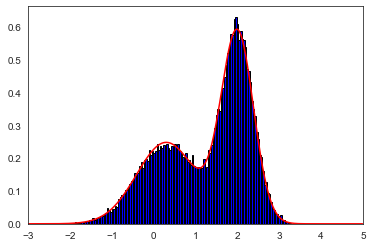

In [15]:
x = np.arange(-3, 5, 0.01) # 

plt.gca().axes.set_xlim(-3, 5)

plt.plot(x, p(x), color = 'r')

plt.hist(sample, color = 'b', bins = 150, density = True, edgecolor = 'k')

plt.show()

使用接受-拒绝采样，我们可以解决一些概率分布不是常见的分布的时候，得到其采样集并用蒙特卡罗方法求和的目的。但是接受-拒绝采样也只能部分满足我们的需求，在很多时候我们还是很难得到我们的概率分布的样本集。比如：

- 对于一些二维分布p(x,y)，有时候我们只能得到条件分布p(x|y)和p(y|x)和,却很难得到二维分布p(x,y)一般形式，这时我们无法用接受-拒绝采样得到其样本集。

- 对于一些高维的复杂非常见分布p(x1,x2,...,xn)，我们要找到一个合适的q(x)和c非常困难。


从上面可以看出，要想将蒙特卡罗方法作为一个通用的采样模拟求和的方法，必须解决如何方便得到各种复杂概率分布的对应的采样样本集的问题。这就需要用到马尔科夫链。

#### 马尔科夫链

马尔科夫链假设某一时刻状态转移的概率只依赖于它的前一个状态。

$P(X_{t+1}|...X_{t−2},X_{t−1},X_{t})=P(X_{t+1}|X_{t})$

即，某一时间点的状态$x_n$在其下一个状态$x_{n+1}$的概率，仅仅取决于现在它所处的状态，而与它如何达到现在的状态无关。

换句话说，该随机过程没有记忆。

考虑以下这样的情况，我们在抛地球仪时，手指会指向陆地或者海洋，每一次抛掷就是一次状态转移。

状态转移的情况有以下四种：

- 陆地 -> 陆地
- 陆地 -> 海洋
- 海洋 -> 陆地
- 海洋 -> 海洋

状态转移矩阵为

$\begin{bmatrix}
     &  陆地 & 海洋\\
陆地& 0.75 & 0.25\\
海洋 & 0.1 & 0.9\\ 
\end{bmatrix}$

In [22]:
A = np.array([[0.75,0.25],
             [0.1,0.9]]) # 定义一个矩阵
print(np.dot([0, 1], A))  # 矩阵乘法

[0.1 0.9]


无论初始状态如何，在经过n次状态转移过后，它处于某一个状态的概率是平稳分布的。

In [25]:
#
def get_matrix_pow(init, matrix, n):
    '''
    init:   初始状态
    matrix: 状态转移矩阵
    n:      状态转移次数
    '''
    if init[0]+init[1]==1:  # 确保初始状态概率之和为1

        ret = init

        rets=[]
        rets= np.array(ret)
        
        for i in range(n):# n次状态转移过程
            ret = np.dot(ret, matrix)# 矩阵乘法
            rets=np.row_stack((rets,ret))# 结果合并
        plt.plot(range(n+1),rets[:,0],color='blue',label='land') # 每一次状态转移，处于陆地的概率
        plt.plot(range(n+1),rets[:,1],color='red',label='sea')   # 每一次状态转移，处于海洋的概率
        plt.legend()
        plt.show()
        return ret
    else:
        raise ValueError("please make sure the sum of input equal to 1, and dim of it is 2")

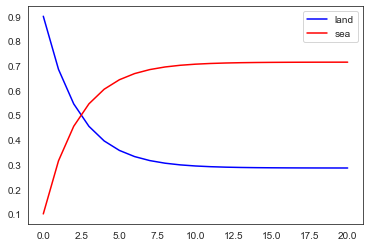

array([0.28582562, 0.71417438])

In [27]:
get_matrix_pow([0.9, 0.1], A, n=20)

In [17]:
get_matrix_pow([0.1,0.9],A,n = 20)

<Figure size 432x288 with 1 Axes>

array([0.28568063, 0.71431937])

我们可以观察到无论初始状态如何，只要状态转移一直持续下去，处在每个状态的概率会服从一个平稳分布。


假定我们可以得到我们需要采样样本的平稳分布所对应的马尔科夫链状态转移矩阵，那么我们就可以用马尔科夫链采样得到我们需要的样本集，进而进行蒙特卡罗模拟。

但是我们该如何得到马尔可夫链的状态转移矩阵呢？这就需要MCMC。

#### MCMC

MCMC，即马尔可夫蒙特卡洛方法，是一组利用马尔可夫链从随机分布中取样的算法。生成的马尔科夫链就是对于目标分布的近似估计。

##### MCMC采样算法如下：

1. 输入任意给定的马尔科夫链状态转移矩阵Q，目标平稳分布$\pi(x)$  ，设定状态转移次数阈值 $n_1$ ，需要的样本数 $n_2$ ;

2. 从任意简单概率分布得到初始状态值 $x_0$ ；

3. for t = 0 in n1 + n2 - 1 

- 从条件概率分布$Q(x|x_t)$得到样本值$x_*$

- 从均匀分布中采样 $U \sim [0,1]$

- 如果 $u<\alpha(x_t,x_*)=\pi(x_*)Q(x_*,x_t)$,则接受$x_t -> x_*$, 即$x_{t+1}=x_*$ 

- 否则不接受转移，$t =max{t-1,0}$

但是这个采样算法还是比较难在实际中应用，因为在第三步中，由于 $\alpha(x_t,x_*)$ 可能非常的小，比如0.1，导致我们大部分的采样值都被拒绝转移，采样效率很低。

有可能我们采样了上百万次马尔可夫链还没有收敛，也就是上面这个 $n_1$ 要非常非常的大，这让人难以接受，怎么办呢？这时就轮到我们的M-H采样出场了。

In [18]:
def norm_dist_prob(theta,loc=3,scale=2): #定义目标分布
    y = norm.pdf(theta, loc=3, scale=2)
    return y

T = 5000 #采样次数5000
pi = [0 for i in range(T)] #用来存储采样点的数组
sigma = 1 #标准差
t = 0 #当前采样次数
while t < T-1:
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    alpha = (norm_dist_prob(pi_star[0])*norm_dist_prob(pi_star[0],loc = pi[t - 1]))   #alpha值

    u = np.random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]

In [19]:
plt.plot(range(5000),pi)
plt.show()

<Figure size 432x288 with 1 Axes>

In [20]:
plt.scatter(pi, norm.pdf(pi, loc=3, scale=2),label='Target Distribution')
num_bins = 50
plt.hist(pi, num_bins, density = True, facecolor='red', alpha=0.7,label='Samples Distribution')
plt.legend()
plt.show()

<Figure size 432x288 with 1 Axes>

##### M-H采样算法

M-H采样是Metropolis-Hastings采样的简称，这个算法首先由Metropolis提出，被Hastings改进，因此被称之为Metropolis-Hastings采样或M-H采样。

M-H采样解决了我们上一节MCMC采样接受率过低的问题。

我们可以取$\alpha(i,j)=min(\frac{\pi(j)Q(j,i)}{\pi(i)Q(i,j)},1 )$ 

M-H 采样算法如下：

1. 输入任意给定的马尔科夫链状态转移矩阵Q，目标平稳分布$\pi(x)$  ，设定状态转移次数阈值 $n_1$ ，需要的样本数 $n_2$ ;

2. 从任意简单概率分布得到初始状态值 $x_0$ ；

3. for t = 0 in n1 + n2 - 1 

- 从条件概率分布$Q(x|x_t)$得到样本值$x_*$

- 从均匀分布中采样 $U \sim [0,1]$

- 如果 $u<\alpha(x_t,x_*)=min(\frac{\pi(j)Q(j,i)}{\pi(i)Q(i,j)},1 )$,则接受$x_t -> x_*$, 即$x_{t+1}=x_*$ 

- 否则不接受转移，t=max{t-1,0}


In [21]:
def norm_dist_prob(theta):#定义目标分布
    y = norm.pdf(theta, loc=3, scale=2)
    return y

T = 5000 #采样次数5000
pi = [0 for i in range(T)] #用来存储采样点的数组
sigma = 1 #标准差
t = 0 #当前采样次数
while t < T-1:
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    alpha = min(1, (norm_dist_prob(pi_star[0]) / norm_dist_prob(pi[t - 1])))   #alpha值

    u = np.random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]



In [22]:
plt.plot(range(5000),pi)
plt.show()

<Figure size 432x288 with 1 Axes>

In [23]:
plt.scatter(pi, norm.pdf(pi, loc=3, scale=2),label='Target Distribution')
num_bins = 50
plt.hist(pi, num_bins, density = True, facecolor='red', alpha=0.7,label='Samples Distribution')
plt.legend()
plt.show()

<Figure size 432x288 with 1 Axes>

## Part 2: MCMC原理

使用MCMC的原因：
- 由于贝叶斯公式分母难以计算
- 由于参数过多后验分布形态复杂

在本节课中，我们首先回顾如何计算后验，以及计算后验面临的问题；

之后，我们介绍如何通过采样的方法解决现有的问题。

### 计算后验面临的问题

**以探究地球海水覆盖率为例。**

- 假设我们获得数据：抛地球仪10次，其中7次海面朝上。
- 在获得数据的同时，我们以二项分布函数作为**似然函数**。
- 假设我们在获得数据以前的**先验**认为：地球海水覆盖率为0.5。

我们的任务是根据数据更新我们的先验。

1. 假设我们获得数据：抛地球仪10次，其中7次海面朝上。

In [25]:
import numpy as np               # numpy 是专门用于数组运算的包
import scipy.stats as st         # 从scipy.stats里载入分布函数
import matplotlib.pyplot as plt  # matplotlib.pyplot 是专门用于画图的包
import seaborn as sns            # seaborn是专门用于绘制统计数据的包
import arviz as az               # arviz 是专门用于探索贝叶斯模型的包

In [26]:
data = [1,1,1,1,1,0,0,1,1,0] # 1代表海面朝上，0代表陆地朝上
print("数据：",data)

数据： [1, 1, 1, 1, 1, 0, 0, 1, 1, 0]


In [27]:
plt.hist(data)
plt.xticks([0,1],labels=["earth","water"])
plt.xlim(-1,2)

(-1.0, 2.0)

<Figure size 432x288 with 1 Axes>

2. 我们的先验：地球海水覆盖率为0.5。
  
由于我们的先验不是分布，而是一个值，因此可以认为我们对先验的信心为100%，即 $prior=1$

In [29]:
prior_θ = 0.5
prior=1 # 由于先验只有一个值，我们用1(100%)表示先验出现的概率
print("先验：地球海水覆盖率为：",prior_θ)

先验：地球海水覆盖率为： 0.5


3. 结合先验参数(prior_θ)与数据(data)计算似然值。

我们选择伯努利分布函数(bernoulli)作为似然函数。

In [30]:
likelihood  = st.bernoulli(prior_θ).pmf(data).prod()
print("根据当前数据与先验得到的似然值：",likelihood)

根据当前数据与先验得到的似然值： 0.0009765625


4. 计算后验，即通过似然值更新先验。

注意：

由于这里是没有考虑贝叶斯公式的分母部分，因此我们得到的是未标准化的 invalid 后验

In [31]:
unstd_posterior = likelihood * prior
print("未标准化的后验：", unstd_posterior)

未标准化的后验： 0.0009765625


**练习：**

当我们假设的先验不同时，似然与后验也会产生相应的变化。

比如，我们尝试将先验(地球海水覆盖率)设为0.5，0.6，和0.7。

- 为了后面方便计算，我们把计算未标准化后验的过程用一个函数包裹起来

该函数的每一步计算过程与之前完全相同

In [32]:
def calculate_posterior(prior_θ, data):
    prior=1
    likelihood  = st.bernoulli(prior_θ).pmf(data).prod()
    unstd_posterior = likelihood * prior
    
    return unstd_posterior

In [33]:
prior_θ = 0.5 # 假设先验为0.5
unstd_posterior = calculate_posterior(prior_θ,data)
print("未标准化的后验：",unstd_posterior)

未标准化的后验： 0.0009765625


In [34]:
import numpy as np               # numpy 是专门用于数组运算的包
import scipy.stats as st         # 从scipy.stats里载入分布函数

# 定义计算后验的函数
def calculate_posterior(prior_θ, data):
    prior=1
    likelihood  = st.bernoulli(prior_θ).pmf(data).prod()
    unstd_posterior = likelihood * prior
    return unstd_posterior
  
########################################################
# 练习
# 请尝试修改先验参数 prior_θ 修改为0.6或者0.7
########################################################

prior_θ = ...
unstd_posterior = calculate_posterior(prior_θ,data)
print("未标准化的后验：",unstd_posterior)

TypeError: '>=' not supported between instances of 'ellipsis' and 'int'

通过定义函数`calculate_posterior`，我们只需要输入先验参数和数据，就可以计算出后验后验(invalid)。

经过尝试可以发现，当我们的先验参数越接近数据中海面出现的频率(0.7)时，后验值最大。

但此时的后验值还很小，还不是一个有效的概率值，接下来我们结合 **有效的先验概率分布**和**贝叶斯公式分母(边际似然)**计算有效的后验概率分布。

**计算valid 后验概率分布**

如果我们假设，海水覆盖面率可能不止是一个值，而可能为0.6，0.7，0.8，其中0.7的可能性最大时：

比如，我们认为海水覆盖率为0.7时的概率为0.5，而海水覆盖率为0.6和0.7的概率为0.25。

此时先验概率的和为1，所以该分布是一个有效的(valid)概率分布。

In [35]:
prior_θs = [0.6,0.7,0.8] # 假设先验为0.6，0.7，0.8
priors = [0.25,0.5,0.25] # 假设我们对不同先验的信心为0.25,0.5,0.25

In [36]:
# 绘制先验分布的概率分布
plt.plot(prior_θs,priors)
plt.xlabel("Prior belief of the proportion of sea surface coverage")
plt.ylabel("Probability")
plt.xticks(prior_θs)

([<matplotlib.axis.XTick at 0x7fbfe2b95fd0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

<Figure size 432x288 with 1 Axes>

接下来我们计算后验概率：
- `calculate_posterior` 是我们定义的计算未标准化的后验
- 因为先验有多个值(0.6,0.7,0.8)，我们通过 for 循环分别计算每一个先验值的后验：
  
  `for prior_θ,prior in zip(prior_θs,priors)`

  因为每一个先验参数有不同的概率，我们通过`zip`函数将两个变量打包在一起，使得可以同时循环两个变量。
- 为了保存循环计算得到的多个后验值，我们把各值加入到一个空数组`unstd_posteriors = []`

  即下面代码`unstd_posteriors += [unstd_posterior]`

In [37]:
# 定义计算后验的函数
def calculate_posterior(prior_θ, prior, data):
    likelihood  = st.bernoulli(prior_θ).pmf(data).prod()
    unstd_posterior = likelihood * prior
    return unstd_posterior

unstd_posteriors = []
for prior_θ,prior in zip(prior_θs,priors):
    unstd_posterior = calculate_posterior(prior_θ,prior,data)
    unstd_posteriors += [unstd_posterior]

Tips: 上面的循环可以写作下面**更简洁**的形式，这得力于python的语法糖。

In [38]:
unstd_posteriors = [calculate_posterior(prior_θ,prior,data) for prior_θ,prior in zip(prior_θs,priors)] 

In [39]:
print("未标准化的后验：",unstd_posteriors)

未标准化的后验： [0.00044789760000000004, 0.0011117830499999999, 0.0004194303999999999]


此时的后验不是有效的概率分布，我们可以通过计算贝叶斯公式中的分母，从而得到出标准化(valid)的后验概率。

In [40]:
posteriors = unstd_posteriors/np.sum(unstd_posteriors)
print("标准化的后验：",posteriors)

标准化的后验： [0.22631252 0.5617588  0.21192868]


可以看到，标准化的后验概率总和为1。

并且参数为0.7时，后验概率最大。数据增强了我们对于参数等于0.7的信心(之前我们认为参数等于0.7的概率为0.5)。

In [41]:
plt.plot(prior_θs,posteriors)
plt.xlabel("θ")
plt.ylabel("posterior probability")

Text(0, 0.5, 'posterior probability')

<Figure size 432x288 with 1 Axes>

**先验为正态分布时，计算后验分布**

同样，我们可以根据上节课的知识，为先验设置一个正态分布，然后再计算后验分布。

我们假设先验参数服从均值为0.5，标准差为0.1的正态分布

In [42]:
prior_θs = np.linspace(0, 1, 100) # 用100个数值 遍历先验参数值从0到1
priors = st.norm.pdf(prior_θs,0.5,0.1)/np.sum(st.norm.pdf(prior_θs,0.5,0.1)) # 先验参数服从均值为0.5，标准差为0.1的正态分布

In [43]:
plt.plot(prior_θs,priors)
plt.xlabel("prior θ")
plt.ylabel("priors probability")

Text(0, 0.5, 'priors probability')

<Figure size 432x288 with 1 Axes>

我们通过上面定义的计算后验的函数`calculate_posterior` 以及刚提到的 for循环计算每一个先验对应的后验值

In [45]:
unstd_posterior = [calculate_posterior(prior_θ,prior,data) for prior_θ,prior in zip(prior_θs,priors)]

In [46]:
plt.plot(prior_θs,unstd_posterior)
plt.xlabel("θ")
plt.ylabel("unstandardized posteriors")

Text(0, 0.5, 'unstandardized posteriors')

<Figure size 432x288 with 1 Axes>

注意，此时y轴表示的不是后验概率。

因此我们需要根据公式 $P(data) =\sum_{\theta}^{} p(data,\theta)=\sum_{\theta}^{} p(data|\theta)p(\theta)$ 计算后验概率。

对应的代码 

- $P(data) =$ `np.sum(unstd_posterior)`
- $p(\theta|data) = \frac{p(data|\theta)p(\theta)}{p(data)}$ 对应 `posterior = unstd_posterior/np.sum(unstd_posterior)`

In [47]:
posterior = unstd_posterior/np.sum(unstd_posterior)

plt.plot(prior_θs, priors, color = 'grey',ls = '--',label="prior")
plt.plot(prior_θs, posterior, color = 'red',label="posterior")
plt.legend()

<Figure size 432x288 with 1 Axes>

### MCMC原理实现过程及其代码

在前面的代码示例中，存在两个问题：
- **我们遍历了所有先验参数的可能性去计算后验分布，然而当参数不止一个时，遍历所有参数非常消耗计算量。**
  
  对应的代码为 `prior_θs = np.linspace(0, 1, 100)`。可以想象，如果参数不止一个，那么prior_θs将不再是一个一维向量。

- **对于复杂的后验分布，公式的分母部分难以计算，所以我们无法得到标准化的后验分布**

  对应代码部分 `np.sum(unstd_posterior)`。可以想象，如果参数不止一个，我们需要对每一个参数都进行求和操作。


使用MCMC的**意义**就在于：

通过采样的方法避免遍历所有的参数值，并且**避免计算分母**。

因此，MCMC的关键在于**如何在后验分布中进行采样**？

**为了了解采样的概念，我们首先从参数范围中随机进行采样**

我们知道参数(海面覆盖率)的范围为0到1，因此我们可以从0到1中随机抽取参数

In [48]:
samples = st.uniform(0, 1).rvs(100) # 我们从一个0到1的均匀分布中采样100次，用samples代表采集到的样本

In [49]:
# 我们也可以通过for循环达到同样的效果
n_iters = 100
samples = {"θ":np.zeros(n_iters)}
for n_iter in range(n_iters):
  samples["θ"][n_iter] = st.uniform(0,1).rvs(1) # 此时，每次采样一次

In [50]:
plt.hist(samples["θ"])

(array([14.,  7., 11.,  9., 13., 10., 14.,  4.,  8., 10.]),
 array([0.00567931, 0.10238004, 0.19908078, 0.29578152, 0.39248226,
        0.489183  , 0.58588374, 0.68258448, 0.77928522, 0.87598595,
        0.97268669]),
 <BarContainer object of 10 artists>)

<Figure size 432x288 with 1 Axes>

我们可以看到，随机采集的参数分布与真实的后验分布差距很大。

### 拒绝采样(reject sampling)

**通过前面学到的*拒绝采样*算法，我们可以优化采集到的样本，使得它更接近后验样本**

具体思路为，我们会利用未标准化的后验，当该后验对应的y轴的值越大时，我们越有可能保留对应的参数。

这里我们重新定义计算后验的函数。

其中，我们定义先验分布为正态分布。
并且，避免参数值超过0-1的范围。

In [52]:
def calculate_posterior(θ, data):
    if 0 <= θ <= 1:                           # 避免参数值超过0-1的范围
      prior = st.norm(0.5, 0.1).pdf(θ)        # 定义先验分布是均值为0.5，标准差是0.1的正态分布。
      likelihood  = st.bernoulli(θ).pmf(data).prod()
      unstd_posterior = likelihood * prior
    else:
        unstd_posterior = -np.inf
        
    return unstd_posterior

- 首先，我们从0到1中随机生成一个参数值：`proposal_θ = st.uniform(0,1).rvs(1)`
- 然后，我们计算该参数值的非标准后验：
  
  `unstd_posterior = calculate_posterior(proposal_θ, prior_θ, data)`。
  
  这里面我们的数据为10次抛地球仪，获得7次海面向上；先验服从均值为0.5标准差为0.1的正态分布。
- 最后，我们生成一个随机数，如果非标准后验的值大于该随机数，我们就接受该参数采样，否则我们保持之前的参数采样：
  
  ```
  if unstd_posterior*1000 > st.uniform(0, 1).rvs(1):
        θ = proposal_θ
  else:
        θ = samples['θ'][n_iter-1]
  ```
        
  可以想象，非标准后验的值越大，对应的参数样本越有可能被保留

我们通过一个**练习**来了解，哪些后验参数容易被接受：

这里我们设置拒绝阈限为0.5 `reject_threshold = 0.5`，

当后验参数对应的y轴数值大于该值，我们接受该后验参数 

```
if unstd_posterior > reject_threshold: 
  print("接受的参数：",θ)
```

In [53]:
import numpy as np               # numpy 是专门用于数组运算的包
import scipy.stats as st         # 从scipy.stats里载入分布函数
import matplotlib.pyplot as plt  # matplotlib.pyplot 是专门用于画图的包

########################################################
# 练习
# 请尝试通过 st.uniform(0, 1).rvs(1) 随机生成一个0-1的参数
########################################################
θ = ...

# 根据数据与先验参数计算后验
data = [1,1,1,1,1,0,0,1,1,0]
unstd_posterior = calculate_posterior(θ, data)
unstd_posterior = unstd_posterior*1000 # 因为unstd_posterior太小，我们将其扩大1000倍, (rethinkg: 为什么？)

# 设定拒绝阈限
reject_threshold = 0.5

print("参数y轴值：",unstd_posterior,"拒绝阈限",reject_threshold)
if unstd_posterior > reject_threshold:
    print("接受的参数：",θ)
else:
    print("拒绝的参数：",θ)

TypeError: '<=' not supported between instances of 'int' and 'ellipsis'

可以发现：该方法与随机抽样**最主要的区别**在于，利用随机抽取的样本计算后验，之后根据后验选择是否接受后验参数

我们通过for循环尝试生成1000个随机的参数(proposal_θ):
```
n_iters = 1000
for n_iter in range(n_iters):
  proposal_θ = st.uniform(0,1).rvs(1)
```

如果参数对应y轴数值的1000倍大于0.5我们接受该参数，否则我们拒绝该参数：
```
reject_threshold = 0.5
if unstd_posterior*1000 > reject_threshold:
  θ = proposal_θ
  samples['θ'][n_iter] = θ
```

In [54]:
data = [1,1,1,1,1,1,1,0,0,0] # 数据与之前相同，10次抛地球仪，我们获得7次海面向上
n_iters = 1000
samples = {"θ":np.zeros(n_iters)}

for n_iter in range(n_iters):
    proposal_θ = st.uniform(0,1).rvs(1)
    unstd_posterior = calculate_posterior(proposal_θ, data)
    
    reject_threshold = 0.5
    if unstd_posterior*1000 > reject_threshold:
        θ = proposal_θ
    else:
        θ = samples['θ'][n_iter-1]

    samples['θ'][n_iter] = θ

我们可以对该分布进行统计推断，如同上一次课程我们对后验分布进行统计推断一样。

In [55]:
az.plot_posterior(samples) # 绘制样本的分布

<AxesSubplot:title={'center':'θ'}>

<Figure size 432x288 with 1 Axes>

In [56]:
az.summary(samples) # 计算样本的均值与HDI

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.556,0.111,0.391,0.727,0.007,0.005,226.0,247.0,NaN


从结果看，采集的参数大多位于0.5-0.7, 这符合真实后验分布的结果。

但该分布并不平滑，并且不太符合正态分布，说明我们的算法需要得到优化。

重要性采样有两个问题：
1. 我们采样参数的过程是随机的`proposal_θ = st.uniform(0,1).rvs(1)`，这样采样参数在分布中peak位置的数量较少，导致采样的效率低。
2. 如果我们设置的**拒绝阈限**太大，那么我们采集到的数据大多都会被拒绝。

通过**练习**了解不同**拒绝阈限**对接受的样本数量的影响

In [57]:
n_iters = 1000
samples_accept = []
samples_reject = []

########################################################
# 练习
# 请尝试设置 reject_threshold 为0-1的任何值
########################################################
reject_threshold = ...

for n_iter in range(n_iters):
    proposal_θ = st.uniform(0,1).rvs(1)
    unstd_posterior = calculate_posterior(proposal_θ, data)
    
    if unstd_posterior*1000 > reject_threshold:
        samples_accept += [proposal_θ[0]]
    else:
        samples_reject += [proposal_θ[0]]

accept_number = [len(samples_accept), len(samples_reject)]
print("接受的样本数量：", accept_number[0], "拒绝的样本数量：", accept_number[1])

fig,ax = plt.subplots()
ax.bar(["accept","reject"],accept_number)
plt.show()

TypeError: '>' not supported between instances of 'float' and 'ellipsis'

**Metropolis-Hastings (HM) 算法**

为了提高采样的效率，减少被拒绝的采样，我们可以使用基于 MCMC 思想的 Metropolis-Hastings (HM) 算法。

其与接受拒绝采样的**区别在于**，我们接受采样的概率与之前的采样的后验有关。

`ratio = unstd_posterior1 / unstd_posterior0`  如果当前采样`unstd_posterior1`的后验的概率(未标准化)大于上一次采样的后验`unstd_posterior0`，那么两次后验的比值 ratio 值越大，那么越有可能接受当前采样的参数。

并且，我们每次采样不是随机采样，而是在当前后验参数附近采样 (根据马尔科夫的性质)：

`proposal_θ1 = st.norm(proposal_θ0, 0.5).rvs(1)` 当前参数 `proposal_θ1` 是从之前参数 `proposal_θ0` 附近采样。

这种根据先前采样的建议(proposal)得到的采样，称为 proposal 参数。 对应采样的分布 `st.norm(proposal_θ0,0.5)` 称为 proposal distribution. 

注意，这个分布里的参数可以自己设定，比如，标准差0.5；或者是将标准差也作为模型的参数；并且 proposal distribution的选择也具有人为性。 这些人为性都影响采样的效率。

In [58]:
n_iters = 1000
samples = {"θ":np.zeros(n_iters)}
proposal_theta1 = 0          # 为当前迭代下的proposal_θ
proposal_theta0 = 0          # 为上一个迭代的proposal_θ
unstd_posterior1 = 0.001 # 为当前迭代下的unstd_posterior
unstd_posterior0 = 0.001 # 为上一个迭代的unstd_posterior

for n_iter in range(n_iters):
    prop_theta1 = st.norm(prop_theta0,0.5).rvs(1)
    unstd_posterior1 = calculate_posterior(prop_theta1, data)
    
    ratio = unstd_posterior1 / unstd_posterior0

    if ratio > st.uniform(0, 1).rvs(1):
        prop_theta0 = prop_theta1
        unstd_posterior0 = unstd_posterior1
        
    samples['θ'][n_iter] = prop_theta0

In [59]:
az.plot_posterior(samples) # 绘制样本的分布

<AxesSubplot:title={'center':'θ'}>

<Figure size 432x288 with 1 Axes>

In [60]:
az.summary(samples) # 计算样本的均值与HDI

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.559,0.085,0.39,0.711,0.007,0.005,147.0,117.0,NaN


可以看到，我们顺利得到了参数的后验分布，并且该结果比重要性采样算法的结果更好。

有了该采样样本，我们就可以用上一节课学习到的统计推断方法分析该采样分布了

同样，我们可以比较 proposal参数在metroplis算法中的接受频率。

In [62]:
n_iters = 1000
samples_accept = []
samples_reject = []

for n_iter in range(n_iters):
    proposal_θ1 = st.norm(proposal_θ0,0.5).rvs(1)
    unstd_posterior1 = calculate_posterior(proposal_θ1, data)
    
    ratio = unstd_posterior1 / unstd_posterior0

    if ratio < st.uniform(0, 1).rvs(1):
        samples_accept += [proposal_θ[0]]
    else:
        samples_reject += [proposal_θ[0]]

accept_number = [len(samples_accept), len(samples_reject)]
print("接受的样本数量：", accept_number[0], "拒绝的样本数量：", accept_number[1])

fig,ax = plt.subplots()
ax.bar(["accept","reject"],accept_number)
plt.show()

接受的样本数量： 708 拒绝的样本数量： 292


<Figure size 432x288 with 1 Axes>

可以看到，metroplis算法的接受效率更好。

需要注意的是，通过MCMC采样得到的是从后验分布中采样得到的参数样本，而不是关于后验分布的函数。

后验分布参数样本相比于后验分布函数的优点在于：
- 方便计算后验分布的平均值等统计值

缺点在于：
- 如果样本无法代表后验分布，基于后验分布的统计推断也会出错

### pymc3

显然通过写for循环来实现MCMC算法还是过于复杂，我们下节课将结合 pymc工具包，简化以上计算。

In [63]:
import pymc3 as pm

data = [1,1,1,1,1,0,0,1,1,0]
with pm.Model() as model:
    # 设定先验
    θ = pm.Normal("θ", 0.5, 0.1)
    # 设定似然函数与数据
    pm.Binomial("samples", n=1, p=θ, observed=data)
    # Sample from the posterior distribution
    samples = pm.sample(1000, return_inferencedata=True)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [64]:
az.plot_dist(samples.posterior["θ"])

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

In [65]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.559,0.086,0.393,0.72,0.002,0.001,1900.0,2332.0,1.0


从PyMC3的采样结果来看，同样采集1000个样本，PyMC3的后验分布明显更加平滑和准确。

这提示我们，即使我们知道采样器的算法和原理，但我们自己写的代码仍然和专业工具包存在差异。

因此更重要的是，我们的学习目标是如何利用优秀的算法和工具完成数据分析，而不是自己研究如何创造算法和工具

总结，MCMC算法的专业术语，包括：

- MCMC samplers：由于MCMC算法的本质是对后验分布进行采样，因此该方法也被叫做MCMC采样器(samplers)。
- iteration，draws，samples：MCMC采样器在采样过程中需要进行循环，每个循环称为一个iteration，每个iteration中采集的参数称作样本samples，也可以叫做draws，就像从抽屉里抽出来一样。
- proposal dsitribution：即参数采样的过程不再是随机采样，而是根据建议分布(proposal dsitribution)进行采样。
- chain：在使用MCMC算法时，我们会同时运行多个“循环”，每一个循环为一条马尔科夫链(chain)。运行多条链的目的在于，可以更高效的采集更多的样本，也可以避免单条链采到的样本不能代表后验分布的影响。


### HMC (Hamiltonian Monte Carlo)

Metropolis-Hastings (HM)的优点：
- MH算法步骤非常精简，每次迭代iteration只有两个步骤
   1. 根据上次采样的参数生成proposal distribution，然后进行采样

   `proposal_θ1 = st.norm(proposal_θ0,0.5).rvs(1)`

   2. 计算拒绝概率(接受／拒绝)

   ```
   unstd_posterior1 = calculate_posterior(proposal_θ1, data)
   ratio = unstd_posterior1 / unstd_posterior0
   if ratio < st.uniform(0, 1).rvs(1): print("接受")
   ```

- MH算法可以从复杂的后验分布中采样，虽然其效率不高。

Metropolis-Hastings (HM)的问题：
- proposal distribution 的标准差太大会导致大量被拒绝的样本，而太小的标准差会导致花费更长时间来“探索分布”

  `proposal_θ1 = st.norm(proposal_θ0,0.5).rvs(1)` 比如将这里的0.5修改为5

- 当模型参数很多的时候，MH 采样的效率非常低，因为它的采样是根据 proposal distribution随机选取的
- 对于高维后验分布，MH 的采样是非常不均匀的


![Image Name](https://cdn.kesci.com/upload/image/rjvgyvcsre.gif?imageView2/0/w/640/h/640)


绿色为接受的采样，红色是拒绝的采样。可以看到HM算法中被拒绝的采样是比较多的。

**HMC (Hamiltonian Monte Carlo)**

为了解决 HM 中 proposal distribution 由于随机采样导致效率低的问题，研究者提出了HMC。

HMC结合物理概念来优化 MCMC：
- HMC 通过基本物理规律 **能量=势能+动能** 假设采样的分布(后验分布)为系统的总能量，然后将该系统分为两个子部分
- 由于动量增加，势能就会减少，因此**系统总能量不会变化**。这说明我们采样的分布不会因为系统的动态变化而变化，这类似于马尔科夫的平稳分布


![Image Name](https://cdn.kesci.com/upload/image/rjviiji42v.gif?imageView2/0/w/640/h/640)


- 势能，与位置有关，比如对于重力势能，高度越高，势能越大。相似的，可以把参数的位置看作高度，把参数对应的似然看作势能。可以结合拒绝采样进行理解，在拒绝采样中，似然值越大对应的参数越有可能被接受，因此，这里势能越大的参数也越有可能被接受。

	```
	unstd_posterior0 = calculate_likelihood(proposal_θ0, data)  # 上一次参数对应的似然值(即势能)
	unstd_posterior1 = calculate_likelihood(proposal_θ1, data)  # 当前次参数对应的似然值
	ratio = unstd_posterior1 / unstd_posterior0                          # 与 HM一样计算两次参数似然的比值
	``` 
	
- 动能，与速度有关，比如动能公式 $\frac{1}{2}mv^2$。其对应的是似然函数的梯度，从下图中可以发现，沿着梯度进行采样可以更多的采样到分布 peak 位置部分的参数。
	
	```
	momentum0 = momentum_dist.rvs()                                                 # 随机生成动能值
	gradient = calculate_gradient(momentum0, likelihood_function)     # 根据动能值计算似然函数的梯度
	momentum1 = momentum0 + gradient                                            # 根据梯度更新动能
	
	# 根据
	momentum_ratio = calculate_likelihood(momentum0, data)/(momentum1, data)
	```


- 需要注意的是，势能会随着动能的变化而变化：

```
proposal_θ1 = unstd_posterior0 + momentum                                # 根据动能更新参数位置
unstd_posterior1 = calculate_likelihood(proposal_θ1, data)             # 根据更新的位置计算势能
```

- 最后结合两部分能量进行判断

```
if ratio*momentum_ratio < st.uniform(0, 1).rvs(1): print("接受")
```


![Image Name](https://cdn.kesci.com/upload/image/rjvh3zx4an.gif?imageView2/0/w/640/h/640)


绿色为接受的采样，红色是拒绝的采样。可以看到HMC几乎没有被拒绝的采样，其采样效率高。

红色的线条是 HMC 表示沿着与梯度有关的 proposal distritbution 进行采样。

HMC 与 HM 相比的**主要区别**在于：
- HMC 凭借更少的迭代数来获得相对多的具有代表性的采样
- HMC 因为每次单次迭代需要计算似然函数的梯度，因此计算的“消耗”更高，但 HMC 仍然比HM效率更高
- HMC 在大多数情况下接受采样的概率比 HM 高

基于HMC，最常用的算法是 No-U-Turn sampler（NUTS），pymc 和 Stan默认使用的也是NUTS算法。


![Image Name](https://cdn.kesci.com/upload/image/rjvix0jc6b.png?imageView2/0/w/320/h/320)


![Image Name](https://cdn.kesci.com/upload/image/rjviyt1d5d.png?imageView2/0/w/320/h/320)

**吉布斯采样 (Gibbs sampling)**

Gibbs sampling 通过从参数的条件分布进行采样或从给定的另一个参数值的概率分布进行采样。

Gibbs sampling 的目的是从难以直接采样的多元概率分布P(x)中生成样本。这个算法基于每一个条件分布$p(x_i|x_i)$进行采样

使用Gibbs sampling对二元高斯分布进行采样

![Image Name](http://gorayni.github.io/assets/posts/gibbs/gibbs2.gif)


相比于MH算法，Gibbs采样不需要考虑多参数的情况，它将接受拒绝采样分别用于每个步骤。

**差分进化算法 (Differential evolution)**

尽管Gibbs采样可以从条件分布进行采样，来获得函数间的相关，但这种采样方法很慢。

还有一个问题就是不相关的建议分布可能与目标分布不匹配。这种不匹配意味着采样时拒绝率会很高。

差分进化算法使用多个链进行采样，并利用各链之间的非独立性来解决参数的相关问题。



差分进化算法使用其他链之间样本点的距离来对当前链的值进行更新。


![Image Name](https://matteding.github.io/images/diff_evol.gif)


其中，$\lambda$为预设值，$\lambda$的取值会影响采样的速度。

### 总结

- the idea of approximation
- MCMC原理
- 其他采样算法简介